# Join the two datasets

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

#### Load datasets:

In [2]:
df_hourly_weather = pd.read_pickle('datasets/hourly_weather.pkl')
df_accidents = pd.read_pickle("datasets/accidents.pkl")

**Check NaN again:**

In [3]:
idx, idy = np.where(pd.isnull(df_accidents))
idx, df_accidents.columns[idy]

(array([], dtype=int64), Index([], dtype='object'))

**Compare dims of the datasets:**

In [4]:
df_hourly_weather.shape

(78707, 14)

In [5]:
df_accidents.shape

(42726, 12)

**Check which columns are in the dfs:**

In [6]:
print('Weather dataset:', list(df_hourly_weather.columns))
print(' ')
print('Accidents dataset:', list(df_accidents.columns))

Weather dataset: ['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min', 'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction', 'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point', 'global_radiation', 'humidity', 'water_level']
 
Accidents dataset: ['date', 'AccidentType', 'AccidentSeverityCategory', 'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle', 'RoadType', 'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N', 'Month', 'WeekDay', 'Hour']


**Notes**
<br>
***Neural Network***:
<br> 
Need to one hot encode object inputs (*normalization will be done when splitting data into train and test*).
<br>
***Random Forest***:
<br>
Only one hot encoding is necessary.
<br><br>
**A: Prediction for accident yes/no**:
<br>
Join accident data on weather data.
<br>
Use only weather data to predict whether an accident happens or not.
<br><br>
**B: Prediction for multi-level**:
<br>
Join weather data on accident data.
<br> 
Could predict the probability of a given type of accident (AccidentSeverity and AccidentType) based on weather data (maybe add location)


### A: Merge and fill nans of date columns:

In [7]:
df_join = pd.merge(df_hourly_weather, df_accidents, on='date', how='left')
df_join.shape

(92081, 25)

In [8]:
df_join.isnull().any()

date                           False
air_temperature                False
water_temperature              False
wind_gust_max_10min            False
wind_speed_avg_10min           False
wind_force_avg_10min           False
wind_direction                 False
windchill                      False
barometric_pressure_qfe        False
precipitation                  False
dew_point                      False
global_radiation               False
humidity                       False
water_level                    False
AccidentType                    True
AccidentSeverityCategory        True
AccidentInvolvingPedestrian     True
AccidentInvolvingBicycle        True
AccidentInvolvingMotorcycle     True
RoadType                        True
AccidentLocation_CHLV95_E       True
AccidentLocation_CHLV95_N       True
Month                           True
WeekDay                         True
Hour                            True
dtype: bool

In [9]:
df_join.dtypes

date                           datetime64[ns]
air_temperature                       float64
water_temperature                     float64
wind_gust_max_10min                   float64
wind_speed_avg_10min                  float64
wind_force_avg_10min                  float64
wind_direction                         object
windchill                             float64
barometric_pressure_qfe               float64
precipitation                         float64
dew_point                             float64
global_radiation                      float64
humidity                              float64
water_level                           float64
AccidentType                           object
AccidentSeverityCategory               object
AccidentInvolvingPedestrian           float64
AccidentInvolvingBicycle              float64
AccidentInvolvingMotorcycle           float64
RoadType                               object
AccidentLocation_CHLV95_E             float64
AccidentLocation_CHLV95_N         

- Fill Month, WeekDay and Hour for weather data:

In [10]:
df_join['Month'].fillna(df_join['date'].dt.month, inplace = True)
df_join['WeekDay'].fillna(df_join['date'].dt.day_name(), inplace = True)
df_join['Hour'].fillna(df_join['date'].dt.hour, inplace = True)
df_join.tail()

,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,...,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,Month,WeekDay,Hour
92076,2019-12-31 18:30:00,1.56,6.80,2.3,1.24,1.0,734,1.54,984.54,0.0,...,as4,0.0,0.0,0.0,rt432,2682276.0,1247052.0,12.0,Tuesday,18.0
92077,2019-12-31 19:30:00,1.34,6.80,2.6,1.44,1.2,963,1.18,984.62,0.0,...,as4,0.0,0.0,0.0,rt433,2683004.0,1247184.0,12.0,Tuesday,19.0
92078,2019-12-31 20:30:00,1.04,6.80,2.8,1.66,1.8,699,0.78,984.76,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,20.0
92079,2019-12-31 21:30:00,1.06,6.76,2.5,1.36,1.2,729,1.00,984.84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,21.0
92080,2019-12-31 22:30:00,0.48,6.70,4.6,3.12,2.2,293,-3.60,985.02,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,22.0


- Convert wind direction from type *object* to type *int*:

In [11]:
df_join['wind_direction'] = [int(i) for i in df_join['wind_direction']]   

- Add dummy for whether an accident happened:

In [12]:
df_join.dtypes

date                           datetime64[ns]
air_temperature                       float64
water_temperature                     float64
wind_gust_max_10min                   float64
wind_speed_avg_10min                  float64
wind_force_avg_10min                  float64
wind_direction                          int64
windchill                             float64
barometric_pressure_qfe               float64
precipitation                         float64
dew_point                             float64
global_radiation                      float64
humidity                              float64
water_level                           float64
AccidentType                           object
AccidentSeverityCategory               object
AccidentInvolvingPedestrian           float64
AccidentInvolvingBicycle              float64
AccidentInvolvingMotorcycle           float64
RoadType                               object
AccidentLocation_CHLV95_E             float64
AccidentLocation_CHLV95_N         

In [13]:
df_join['Accident'] = np.where(df_join.isnull().any(axis = 1), 0, 1)

- One Hot Encoding:

In [14]:
categorical_cols = list(df_join.select_dtypes(include=['object']).columns)
categorical_cols.extend(['Month', 'Hour']) # these need to be one hot encoded as well
df_join = pd.get_dummies(df_join, columns = categorical_cols, dtype= bool, drop_first= True)
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'Accident', 'AccidentType_at00',
       'AccidentType_at1', 'AccidentType_at2', 'AccidentType_at3',
       'AccidentType_at4', 'AccidentType_at5', 'AccidentType_at6',
       'AccidentType_at7', 'AccidentType_at8', 'AccidentType_at9',
       'AccidentSeverityCategory_as2', 'AccidentSeverityCategory_as3',
       'AccidentSeverityCategory_as4', 'RoadType_rt431', 'RoadType_rt432',
       'RoadType_rt433', 'RoadType_rt434', 'RoadType_rt439', 'WeekDay_Monday',
       'WeekDay_Saturday', 'WeekDay_Sunday', 'WeekDay_Thursday',
       'WeekDay_Tuesday',

In [15]:
df_join.head()

,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,...,Hour_14.0,Hour_15.0,Hour_16.0,Hour_17.0,Hour_18.0,Hour_19.0,Hour_20.0,Hour_21.0,Hour_22.0,Hour_23.0
0,2011-01-01 00:30:00,2.233333,5.20,2.4,1.216667,1.216667,1785,2.20,974.55,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2011-01-01 01:30:00,2.380000,5.20,2.8,0.860000,0.860000,1076,2.16,973.98,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 03:30:00,2.500000,5.16,1.9,0.520000,0.520000,1122,2.54,973.42,0.0,...,False,False,False,False,False,False,False,False,False,False


In [16]:
df_join.dtypes

date                    datetime64[ns]
air_temperature                float64
water_temperature              float64
wind_gust_max_10min            float64
wind_speed_avg_10min           float64
                             ...      
Hour_19.0                         bool
Hour_20.0                         bool
Hour_21.0                         bool
Hour_22.0                         bool
Hour_23.0                         bool
Length: 78, dtype: object

- Convert boolean types from True/False to 1/0:

In [17]:
bool_cols = list(df_join.select_dtypes(include=['bool']).columns)
df_join[bool_cols] = 1*df_join[bool_cols]

- Remove accident type specific columns:

In [18]:
#remove accident type specific columns:
def remove_cols(df):
    
    acc_spec_cols = [df[column].name for column in df if df[column].name.startswith('Accident') and df[column].name != 'Accident']
    acc_spec_cols.extend([df[column].name for column in df if df[column].name.startswith('RoadType')])
    
    return df.drop(acc_spec_cols, axis = 1)

In [19]:
df_join = remove_cols(df_join)

In [20]:
df_join.shape

(92081, 55)

In [21]:
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level', 'Accident',
       'WeekDay_Monday', 'WeekDay_Saturday', 'WeekDay_Sunday',
       'WeekDay_Thursday', 'WeekDay_Tuesday', 'WeekDay_Wednesday', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
       'Hour_1.0', 'Hour_2.0', 'Hour_3.0', 'Hour_4.0', 'Hour_5.0', 'Hour_6.0',
       'Hour_7.0', 'Hour_8.0', 'Hour_9.0', 'Hour_10.0', 'Hour_11.0',
       'Hour_12.0', 'Hour_13.0', 'Hour_14.0', 'Hour_15.0', 'Hour_16.0',
       'Hour_17.0', 'Hour_18.0', 'Hour_19.0', 'Hour_20.0', 'Hour_21.0',
       'Hour_22.0', 'Hour_23.0'],
      dtype='object')

In [22]:
df_join.to_csv('datasets\\dataset.csv')

In [23]:
df_join.to_csv('datasets/dataset_accident_pred.csv')

### B: Merge weather on accident data for multilevel prediction

In [24]:
df_join_multi = pd.merge(df_accidents, df_hourly_weather, on='date', how='left')
df_join_multi.shape

(42726, 25)

In [25]:
df_join_multi.isnull().any()

date                           False
AccidentType                   False
AccidentSeverityCategory       False
AccidentInvolvingPedestrian    False
AccidentInvolvingBicycle       False
AccidentInvolvingMotorcycle    False
RoadType                       False
AccidentLocation_CHLV95_E      False
AccidentLocation_CHLV95_N      False
Month                          False
WeekDay                        False
Hour                           False
air_temperature                 True
water_temperature               True
wind_gust_max_10min             True
wind_speed_avg_10min            True
wind_force_avg_10min            True
wind_direction                  True
windchill                       True
barometric_pressure_qfe         True
precipitation                   True
dew_point                       True
global_radiation                True
humidity                        True
water_level                     True
dtype: bool

In [26]:
#drop nan columns
df_join_multi = df_join_multi.dropna()

#convert wind direction to type integer
df_join_multi['wind_direction'] = [int(i) for i in df_join_multi['wind_direction']] 

#one hot encoding of accident severity category
categorical_cols = list(df_join_multi.select_dtypes(include=['object']).columns)
categorical_cols.extend(['Month', 'Hour']) # these need to be one hot encoded as well
df_join_multi = pd.get_dummies(df_join_multi, columns = categorical_cols, dtype= bool, drop_first= True)
#convert boolean to integers
bool_cols = list(df_join_multi.select_dtypes(include=['bool']).columns)
df_join_multi[bool_cols] = 1*df_join_multi[bool_cols]

df_join_multi.columns

Index(['date', 'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'air_temperature', 'water_temperature',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'wind_force_avg_10min',
       'wind_direction', 'windchill', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'global_radiation', 'humidity',
       'water_level', 'AccidentType_at00', 'AccidentType_at1',
       'AccidentType_at2', 'AccidentType_at3', 'AccidentType_at4',
       'AccidentType_at5', 'AccidentType_at6', 'AccidentType_at7',
       'AccidentType_at8', 'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'RoadType_rt431', 'RoadType_rt432', 'RoadType_rt433', 'RoadType_rt434',
       'RoadType_rt439', 'WeekDay_Monday', 'WeekDay_Saturday',
       'WeekDay_Sunday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_We

In [27]:
df_join_multi.columns

Index(['date', 'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'air_temperature', 'water_temperature',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'wind_force_avg_10min',
       'wind_direction', 'windchill', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'global_radiation', 'humidity',
       'water_level', 'AccidentType_at00', 'AccidentType_at1',
       'AccidentType_at2', 'AccidentType_at3', 'AccidentType_at4',
       'AccidentType_at5', 'AccidentType_at6', 'AccidentType_at7',
       'AccidentType_at8', 'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'RoadType_rt431', 'RoadType_rt432', 'RoadType_rt433', 'RoadType_rt434',
       'RoadType_rt439', 'WeekDay_Monday', 'WeekDay_Saturday',
       'WeekDay_Sunday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_We

**Thoughts on location variable:**
<br>
Normalizing the location code doesn't really make sense I guess... Therefore, we could use frequency of accident location as value and normalize it.


#### Trying out if neural network works

In [28]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import keras
import tensorflow
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Epoch 1/50
921/921 [==============================] - 2s 797us/step - loss: 0.2300 - accuracy: 0.6108 - val_loss: 0.2005 - val_accuracy: 0.7022
Epoch 2/50
921/921 [==============================] - 1s 594us/step - loss: 0.1974 - accuracy: 0.7092 - val_loss: 0.1996 - val_accuracy: 0.7040
Epoch 3/50
921/921 [==============================] - 1s 588us/step - loss: 0.1965 - accuracy: 0.7103 - val_loss: 0.1993 - val_accuracy: 0.7045
Epoch 4/50
921/921 [==============================] - 1s 585us/step - loss: 0.1962 - accuracy: 0.7105 - val_loss: 0.1992 - val_accuracy: 0.7046
Epoch 5/50
921/921 [==============================] - 1s 579us/step - loss: 0.1960 - accuracy: 0.7111 - val_loss: 0.1990 - val_accuracy: 0.7049
Epoch 6/50
921/921 [==============================] - 1s 627us/step - loss: 0.1958 - accuracy: 0.7109 - val_loss: 0.1987 - val_accuracy: 0.7050
Epoch 7/50
921/921 [==============================] - 1s 581us/step - loss: 0.1954 - accuracy: 0.7110 - val_loss: 0.1980 - val_accuracy:

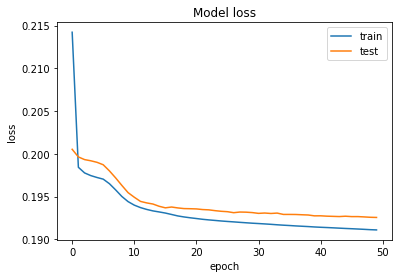

In [30]:
Y = np.array(df_join['Accident'])
X = np.array(df_join.drop(['Accident', 'date'], 1))
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, Y, test_size=0.2, random_state=2)
scaler = MinMaxScaler()
scaler.fit(X_train_80)
X_train_80 = scaler.transform(X_train_80)
X_test_20 = scaler.transform(X_test_20)

#training and evaluating neural network
NeuralNet = Sequential([
        Dense(16, input_dim= X_train_80.shape[1], activation='sigmoid'),
        Dense(4, activation = 'relu'),
        Dense(1, activation='sigmoid'),
])
NeuralNet.compile(loss ='MSE', optimizer ='adam', metrics = ['accuracy'])
historyNet = NeuralNet.fit(X_train_80, y_train_80, validation_split = 0.2, epochs=50, batch_size=64, 
                              shuffle = False, verbose = 1)
scores = NeuralNet.evaluate(X_test_20, y_test_20, verbose=1)
print("%s: %.2f%%" % (NeuralNet.metrics_names[1], scores[1]*100))
plt.plot(historyNet.history['loss'])
plt.plot(historyNet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()